In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect
from numpy.fft import fft
from numpy.fft import fftshift


class LogScaler:
    #Log normalization and data scaling
    
    def __init__(self):
        self._min0 = None
        self._max = None
        pass

    def fit(self, X, y=None):
        self._min0 = X.min(axis=0)
        self._max = np.log(X + np.abs(self._min0) + 1).max()

    def fit_transform(self, X, y=None):
        self._min0 = X.min(axis=0)
        X_norm = np.log(X + np.abs(self._min0) + 1)
        self._max = X_norm.max()
        return X_norm / self._max

    def transform(self, X, y=None):
        X_norm = np.log(X + np.abs(self._min0) + 1).clip(0, None)
        return (X_norm / self._max).clip(0, 1)


class FftTransformer:
    # Image transformer based on fast fourier transform

    def __init__(self, pixels=124):
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        self._xrot = None

    def fft_fit(self,X):     
        z1_lst=[]
        z2_lst=[]

        for cur_x in range(len(X)):
            x_ft = fftshift(fft(X[cur_x]))
                 
            real_lst =[0]*len(x_ft)
            imag_lst= [0]*len(x_ft)

            for i in range(len(x_ft)):
                real_lst[i] = x_ft[i].real
                imag_lst[i] = x_ft[i].imag

            q1, q3 = np.percentile(sorted(real_lst), [10, 90])
            iqr = q3 - q1
    
            # find lower and upper bounds
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            outliers=[]
            outliers_idx=[]
            for i in range(len(real_lst)):
                if real_lst[i] <= lower_bound or real_lst[i] >= upper_bound:
                    outliers.append(real_lst[i])
                    outliers_idx.append(i)
            
            for i in range(len(outliers_idx)):
                real_lst[outliers_idx[i]]=0
            
            # imag 
            q1, q3 = np.percentile(sorted(imag_lst), [10, 90])
            iqr = q3 - q1
    
            # find lower and upper bounds
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            outliers=[]
            outliers_idx=[]
            for i in range(len(imag_lst)):
                if imag_lst[i] <= lower_bound or imag_lst[i] >= upper_bound:
                    outliers.append(imag_lst[i])
                    outliers_idx.append(i)
            
            for i in range(len(outliers_idx)):
                imag_lst[outliers_idx[i]]=0

            z1_lst.append(np.array(real_lst))
            z2_lst.append(np.array(imag_lst))
    
        z1_lst = np.mean(np.array(z1_lst),axis=0) 
        z2_lst = np.mean(np.array(z2_lst),axis=0)

        real_mt = np.empty(shape=(x_ft.shape[0],1))
        real_mt.fill(0)
        imag_mt = np.empty(shape=(x_ft.shape[0],1))
        imag_mt.fill(0)

        for i in range(len(x_ft)):
            cur_real = z1_lst[i]
            real_mt[i] = cur_real

            cur_imag = z2_lst[i]
            imag_mt[i] = cur_imag

        z1 = real_mt
        z2 = imag_mt
        full_mt = np.hstack((z1,z2))
    
        return full_mt

    def fit(self, X, y=None, plot=False):
        x_new = self.fft_fit(X)        

        # get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices

        hull_points = x_new[chvertices]

        # get minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)
        
        # matrix rotation
        self._xrot = np.dot(mbr_rot, x_new.T).T
        
        # get feature coordinates from pixel dimension
        self._calculate_coords()

        #  rotation diagram plot
        if plot is True:
            plt.scatter(x_new[:, 0], x_new[:, 1], s=1,
                        cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
            plt.fill(x_new[chvertices, 0], x_new[chvertices, 1],
                     edgecolor='r', fill=False)
            plt.fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        # Image matrix dimensions
        # Returns:
        #     tuples: (height, width)

        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        # set image matrix dimension

        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):

        # Calculate matrix coordinates of each feature based on the pixel dimensions


        cur_xrp = self._xrot[:, 0]
        cur_yrp = self._xrot[:, 1] 

        ax0_coord = np.digitize(
            cur_xrp,
            bins=np.linspace(min(cur_xrp), max(cur_xrp),
                             self._pixels[0])
        ) - 1
        ax1_coord = np.digitize(
            cur_yrp,
            bins=np.linspace(min(cur_yrp), max(cur_yrp),
                             self._pixels[1])
        ) - 1

        self._coords = np.stack((ax0_coord, ax1_coord), axis=1)

    def transform(self, X):
 
        img_coords = pd.DataFrame(np.vstack((
            self._coords.T,
            X
        )).T).groupby([0, 1], as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

    
        img_matrices = np.array([self._mat_to_rgb(m) for m in img_matrices])
        
        return img_matrices

    def fit_transform(self, X, **kwargs):

        self.fit(X)
        return self.transform(X, **kwargs)

    def feature_density_matrix(self):

        fdmat = np.zeros(self._pixels)
        np.add.at(fdmat, tuple(self._coords.T), 1)
        return fdmat

    def coords(self):
        #Get feature coordinates

        return self._coords.copy()

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.
        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.
        Args:
            hull_points : an nx2 matrix of hull coordinates
        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2
        # calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)
        # find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            -np.sin(angles),
            np.sin(angles),
            np.cos(angles)]).T
        rotations = rotations.reshape((-1, 2, 2))
        # apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)
        # find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)
        # find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)
        # return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]
        # generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

    @staticmethod
    def _mat_to_rgb(mat):
        """Convert image matrix to numpy rgb format
        Args:
            mat: {array-like} (M, N)
        Returns:
            An numpy.ndarry (M, N, 3) with orignal values repeated across
            RGB channels.
        """
        return np.repeat(mat[:, :, np.newaxis], 3, axis=2)

In [3]:
import h5py

In [4]:
h5f = h5py.File('/content/drive/MyDrive/combined/sorted_h5_data/Kidney-counts_x_train.h5','r')
x_train = h5f['dataset_1'][:]
h5f.close()


In [5]:
ln = LogScaler()

x_train = ln.fit_transform(x_train)


In [6]:
it = FftTransformer(pixels=124)


In [7]:
pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=12c86f23e5746d28185a9ceef7539ba17371a0fee802fe647a6ff606fbbc0b41
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [8]:
%load_ext memory_profiler

peak memory: 266.93 MiB, increment: 0.15 MiB


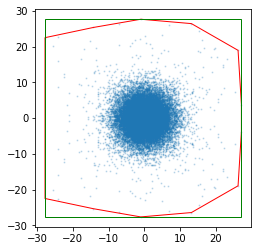

CPU times: user 27.2 s, sys: 386 ms, total: 27.5 s
Wall time: 32.6 s


In [9]:
%%time
%memit


_ = it.fit(x_train, plot=True)

x_train = it.transform(x_train)